## Import libraries

In [1]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

## Distorted Image - an intuitive idea

In this step, we intentionally draw 2 borderlines of the chesseboard for an intuitive idea of how distorted our image is. It should not affect the calculation process and final result (indeed, we just draw, nothing more nothing less). Clearly, the `pt1` and `pt2` parameters should be adjusted ragarding the particular current-considered image.

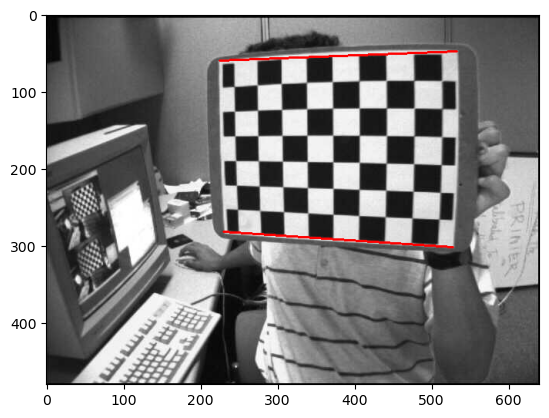

In [2]:
# Import the image
img = cv.imread('images/left01.jpg')

# Borderline
cv.line(img=img, pt1=(225, 60), pt2=(533,48), color=(255, 0, 0), thickness=2)
cv.line(img=img, pt1=(230, 282), pt2=(528, 302), color=(255, 0, 0), thickness=2)

# Show the image with borderline
plt.imshow(img)

## Solution - Methods

Assume that we have a bunch of images from an identical camera of an identical checkerboard.

In [3]:
def getObjImgPoints(CHECKERBOARD, criteria, objp, plot=True):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob('images/*.jpg')

    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(image=gray, 
                                                patternSize=CHECKERBOARD, 
                                                flags=None)
        
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(image=gray,
                                       corners=corners, 
                                       winSize=(11,11), 
                                       zeroZone=(-1,-1), 
                                       criteria=criteria)
            imgpoints.append(corners2)
            
            # Draw and display the corners
            if (plot):
                cv.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
                plt.figure()
                plt.imshow(img)

    return objpoints, imgpoints

$x_{distorted} = x_{real}(1 + k_1r^2 + k_2r^4 + k_3r^6)$

$y_{distorted} = y_{real}(1 + k_1r^2 + k_2r^4 + k_3r^6)$

$x_{distorted} = x + [ 2p_1xy + p_2(r^2+2x^2)] \\ y_{distorted} = y + [ p_1(r^2+ 2y^2)+ 2p_2xy]$


$k_1$, $k_2$, $k_3$ are returned with camera calibration

After having a bunch of points (or equations) above, we are now able to solve the equations for Instrinsic and Extrinsic params by using `cv.calibrateCamera` method in OpenCV. 5 critical inputs:
- `objectPoints`: 3D chessboard points
- `imagePoints`: known position of the corners
- `imageSize`: size of the image
- `cameraMatrix`: Intrinsic camera matrix
- `distCoeffs`: Lens distortion coefficients


There will be 5 obtained outputs:
- `ret`: root mean square (RMS) re-projection error
- `mtx`: The 3x3 matrix $K$ excluding the skew parameter $s$
- `dist`: Lens distortion coefficients
- `rvecs`: Rotation vectors
- `tvecs`: Translation vectors

In [4]:
def undistortedImg(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objectPoints=objpoints,
                                                      imagePoints=imgpoints,
                                                      imageSize=gray.shape[::-1],
                                                      cameraMatrix=None,
                                                      distCoeffs=None)
    
    h, w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    
    return dst, roi

In [5]:
def plotDistUndist(img, roi, dst, resultTitle='images/calibresult.png'):
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    
    cv.imwrite(resultTitle, dst)

    plt.figure(figsize=(15, 30))
    plt.subplot(121)
    plt.title('distorted')
    plt.imshow(img)
    plt.subplot(122)
    plt.title('undistorted')
    plt.imshow(dst)

## Solution - Complete and Test

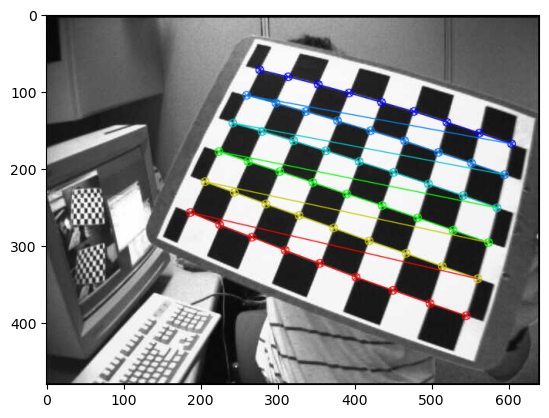

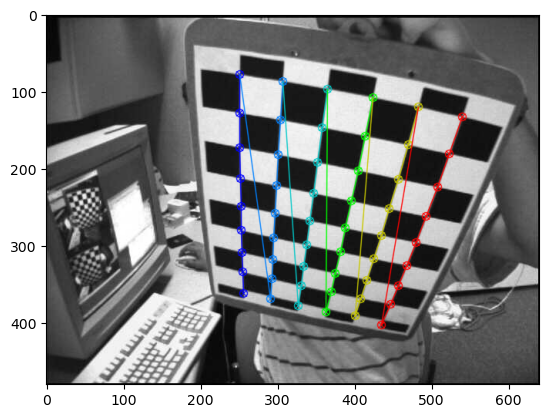

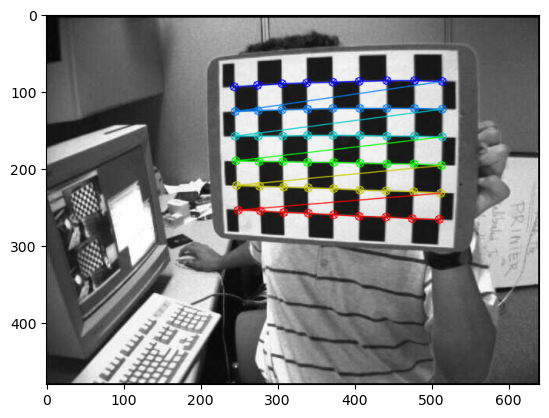

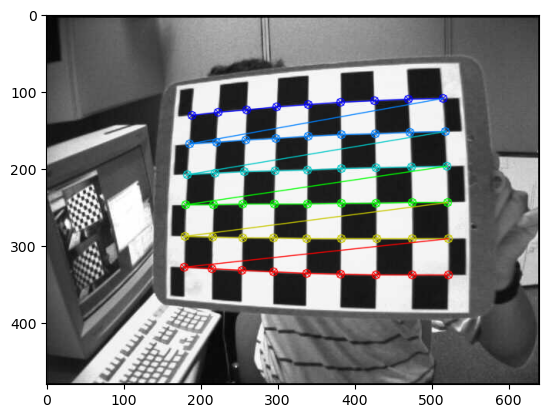

In [6]:
# Defining the dimensions of checkerboard
CHECKERBOARD = (9, 6)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# Get object points and image points from all the images.
objpoints, imgpoints = getObjImgPoints(CHECKERBOARD, criteria, objp)

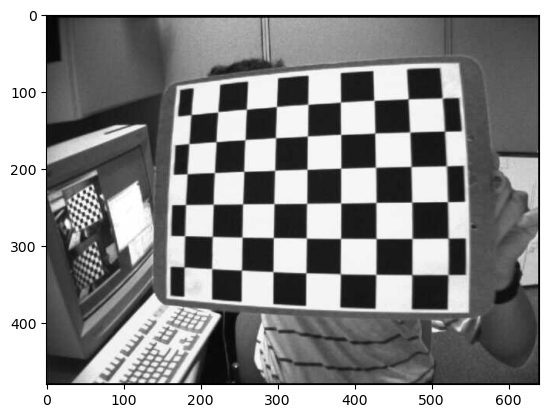

In [7]:
# Import Image
inputName = 'images/left04.jpg'
img = cv.imread(inputName)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Show the image
plt.imshow(img)

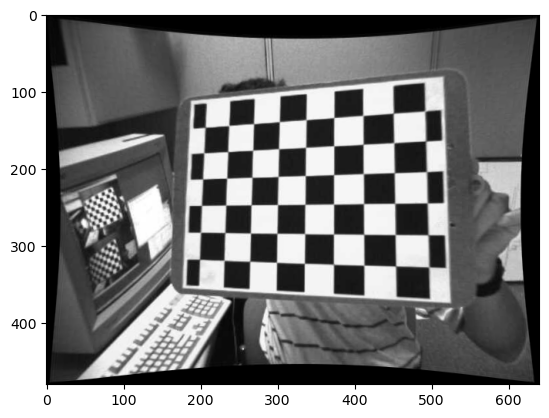

In [8]:
# Undistort
dst, roi = undistortedImg(img, objpoints, imgpoints)
# plot
plt.imshow(dst)

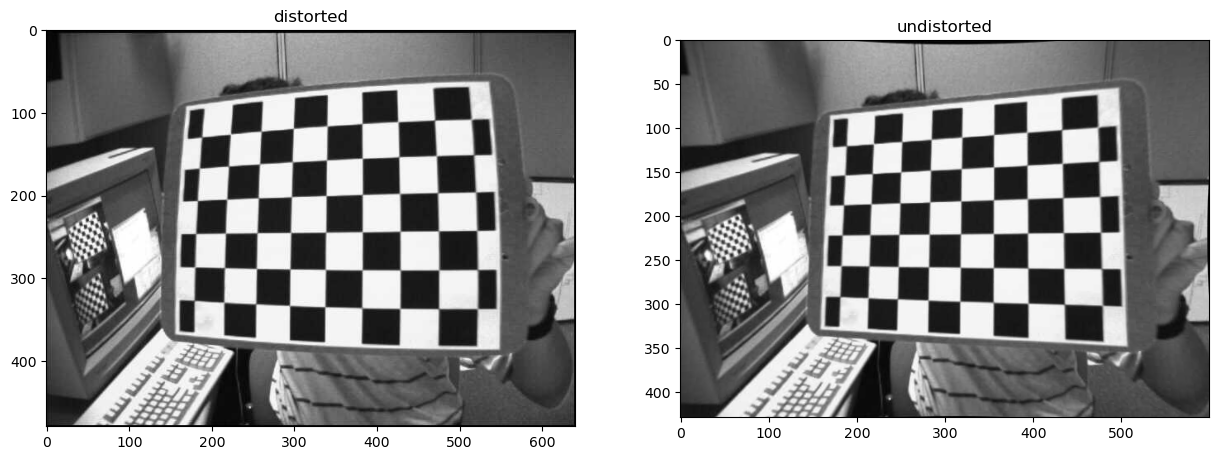

In [9]:
# Plot Before - After
plotDistUndist(img, roi, dst, resultTitle=inputName[:-4]+'_undistorted.png')